My notes from working through section 2, data and sampling distributions, of [Practical statistics for data science](https://learning.oreilly.com/library/view/practical-statistics-for/9781492072935/), to revise consepts and get comfortable implementing them in Python.

Terminology
- Stochastic is a synonym for random. A stochastic process is a random process. The distinction between *stochastics* and *statistics* is that a stochastic processes generate the data we analyse in statistics.

Sampling

- We rely on a sample to learn about a larger population.
- We thus need to make sure that the sampling procedure is free of bias, so that units in the sample are representative of those in the population.
- While representativeness cannot be achieved perfectly, it's important to ensure that non-representativeness is due to random error and not due to systematic bias.
- Random errors produce deviations that vary over repeated samples, while systematic bias persists. Such selection bias can lead to misleading and ephemeral conclusions.
- Two basic sampling procedures are simple random sampling (randomly select $n$ units from a population of $N$) and stratified random sampling (randomly select $n_s$ from each stratum $S$ of a population of $N$).
- The mean outcome of the sample is denoted $\bar{x}$, that of the population $\mu$.

Selection bias

- Using the data to answer many questions will eventually reveal something interesting by mere chance (if 20,000 people flip a coin 10 times, some will have 10 straight heads). This is sometimes called the Vast Search Effect.
- Common types of selection bias in data science:
    - The vast search effect
    - Nonrandom sampling
    - Cherry-picking data
    - Selecting specific time-intervals
    - Stopping experiments prematurely
- Ways to guard against selection bias: have one or many holdout datasets to confirm your results.
- Regression to the mean results form a particular kind of selection bias in a setting where we measure outcomes repeatedly over time: when luck and skill combine to determine outcomes, winners of one period will be less lucky next period and perform closer to the mean performer.

Sampling distributions

- A sampling distribution is the distribution of a statistic (e.g. the mean) over many repeated samples. Classical statistics is much concerned with making inferences from samples about the population based on such statistics.
- When we measure an attribute of the population based on a sample using a statistic, the result will vary over repeated samples. To capture by how much it varies, we are concerned with the sampling variability.

- Key distinctions:
    - The data distribution is the distribution of the data in the sample, the sampling distribution is the distribution of the sample statistic.
    - The standard deviation is a measure of spread of the data distribution, the standard error a measure of spread of the sampling distribution.

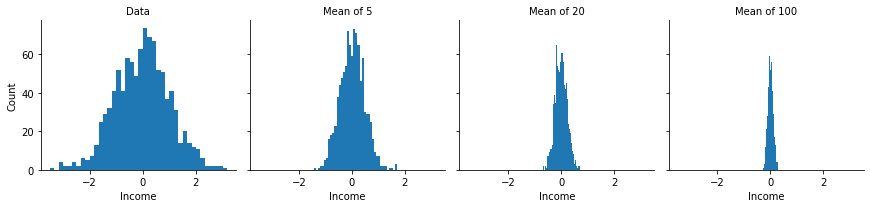

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt

mean, sd, N = 0, 1, 1_000_000
full_data = norm.rvs(mean, sd, N)

sample_data = pd.DataFrame({
    'income': np.random.choice(full_data, 1000),
    'type': 'Data'
})

mof5 = pd.DataFrame({
    'income': [np.random.choice(full_data, 5).mean() for _ in range(1000)],
    'type':'Mean of 5'
})

mof20 = pd.DataFrame({
    'income': [np.random.choice(full_data, 20).mean() for _ in range(1000)],
    'type':'Mean of 20'
})

mof100 = pd.DataFrame({
    'income': [np.random.choice(full_data, 100).mean() for _ in range(1000)],
    'type':'Mean of 100'
})

results = pd.concat([sample_data, mof5, mof20, mof100])

g = sns.FacetGrid(results, col='type')
g.map(plt.hist, 'income', bins=40)
g.set_axis_labels('Income', 'Count')
g.set_titles('{col_name}');

Plots show that:
- Data distribution has larger spread than sampling distributions (each data point is a special case of a sample with n = 1)
- The spread of sampling distributions decreases with increasing sample size

Degrees of freedom

- The number of parameters you had to estimate en route to calculate the desired statistic ([source](http://onlinestatbook.com/2/estimation/df.html)). If you calculate sample variance with an estimated mean rather than a known mean, you have to estimate the sample mean first and thus loose 1 degree of freedom. Hence, you'd divide the sum of squared deviations from the (estimated) mean by n-1 rather than n.

Central limit theorem

- The second point above is an instance of the central limit theorem, which states that means from multiple samples are normally distributed even if the underlying distribution is not normal, provied that the sample size is large enough.

- More precisely: Suppose that we have a sequence of independent and identically distributed (iid) random variables $\{x_1, ..., x_n\}$ drawn from a distribution with expected value $\mu$ and finite variance given by $\sigma^2$, and we are interested in the mean value $\bar{x} = \frac{x_1 + ... + x_n}{n}$. By the law of large numbers, $\bar{x}$ converges to $\mu$. The central limite theorem describes the shape of the random variation of $\bar{x}$ around $\mu$ during this convergence. In particular, for large enough $n$, the distribution of $\bar{x}$ will be close to a normal distribution with mean $\mu$ and standard deviation $\sigma/n$.

- This is useful because it means that irrespective of the underlying distribution (i.e. the distribution of the values in our sequence above), we can use the normal distribution and approximations to it (such as the t-distribution) to calculate sample distributions when we do inference. Because of this, the CLT is at the heart of the theory of hypothesis testing and confidence intervals, and thus of much of classical statistics.

- For experiments, this means that our estiamted treatment effect is normally distributed, which is what allows us to draw inferences from our experimental setting ot the population as a whole. The CLT is thus at the heart of the experimental approach.

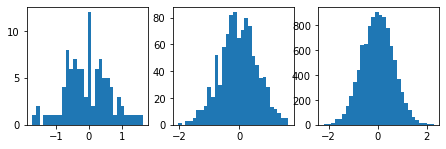

In [19]:
# CLT demo

from scipy.stats import norm, gamma
import matplotlib.pyplot as plt

def means(n):
    return [np.mean(norm.rvs(0, 2, 10)) for _ in range(n)]

plt.subplots(figsize=(10,10))

plt.subplot(441)
plt.hist(means(100), bins=30)
plt.subplot(442)
plt.hist(means(1000), bins=30)
plt.subplot(443)
plt.hist(means(10000), bins=30);

Standard error

- The standard error is a measure for the variability of the sampling distribution. 
- It is related to the standard deviation of the observations, $\sigma$ and the sample size $n$ in the following way:

$$
se = \frac{\sigma}{\sqrt{n}}
$$

- The relationship between sample size and se is sometimes called the "Square-root of n rule", since reducing the $se$ by a factor of 2 requires an increase in the sample size by a factor of 4.

Bootstrap

- In practice, we often use the bootstrap to calculate standard errors of model parameters or statistics.
- Conceptually, the bootstrap works as follows: 1) we draw an original sample and calculate our statistic, 2) we then create a blown-up version of that sample by duplicating it many times, 3) we then draw repeated samples from the large sample, recalculate our statistic, and calculate the standard deviation of these statistics to get the standard error.
- To achieve this easily, we can skip step 2) by simply sampling with replacement from the original distribution in step 3).
- The full procedure makes clear what the bootstrap results tell us, however: they tell us how lots of additional samples would behave if they were drawn from a population like our original sample.
- Hence, if the original sample is not representative of the population of interest, then bootstrap results are not informative about that population either.
- The bootstrap can also be used to improve the performance of classification or regression trees by fitting multiple trees on bootstrapped sample and then averaging their predictions. This is called "bagging", short for "bootstrap aggregating".


In [25]:
# A simple bootstrap implementation

from sklearn.utils import resample

mean, sd, N = 0, 5, 1000
original_sample = norm.rvs(mean, sd, N)

results = []
for nrepeat in range(1000):
    sample = resample(original_sample)
    results.append(np.median(sample))

print('Bootstrap Statistics:')
print(f'Original: {np.median(original_sample)}')
print(f'Bias: {np.median(results) - np.median(original_sample)}')
print(f'Std. error: {np.std(results)}')

Bootstrap Statistics:
Original: 0.028785991557600685
Bias: -0.0017687396759709026
Std. error: 0.15409722327225703


Confidence intervals

- A CI is another way to learn about the variability of a test statistic. 
- It can be calculated using the (standard) normal distribution or the t-distribution (if sample sizes are small).
- But for data science purposes we can compute a x percent CI from the bootstrap, following this algorithm: 1) Draw a large number of bootstrap samples and calculate the statistic of interest, 2) Trim [(100-x)/2] percent of the bootstrap results on either end of the distribution, 3) the trim points are the end point of the CI.

The normal distribution

- Useful not mainly because data is often normally distributed, but because sample distributions of statistics (as well as errors) often are.
- But rely on normality assumption only as a last resort if using empirical distributions or bootstrap is not available. 

Q-Q plots

- Q-Q plots (for quantile-quantile plot) help us compare the quantiles in our dataset to the quantiles of a theoretical distribution to see whether our data follows this distribution (I'll refer to the normal distribution below to fix ideas).
- In general, the x percent quantile is a point in the data such that x percent of the data fall below it (this point is also the xth percentile).
- To create a Q-Q plot, we proceed as follows: First, we split the data into quantiles such that each data point represents its own quantiles. Second, we split the normal distribution into an equal number of quantiles (for the normal distribution, quantiles are intervals of equal probability mass). Third, we mark the quantiles for the data on the y-axis and for the normal distribution on the x-axis. Finally, we use these points as coordinates for each quantile in the plot. (See [this](https://www.youtube.com/watch?v=okjYjClSjOg) helpful video for more details on how to construct Q-Q plots, and [this](https://towardsdatascience.com/explaining-probability-plots-9e5c5d304703) useful article for details on probability plots more generally.)

/Users/fgu/miniconda3/envs/habits/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/fgu/miniconda3/envs/habits/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


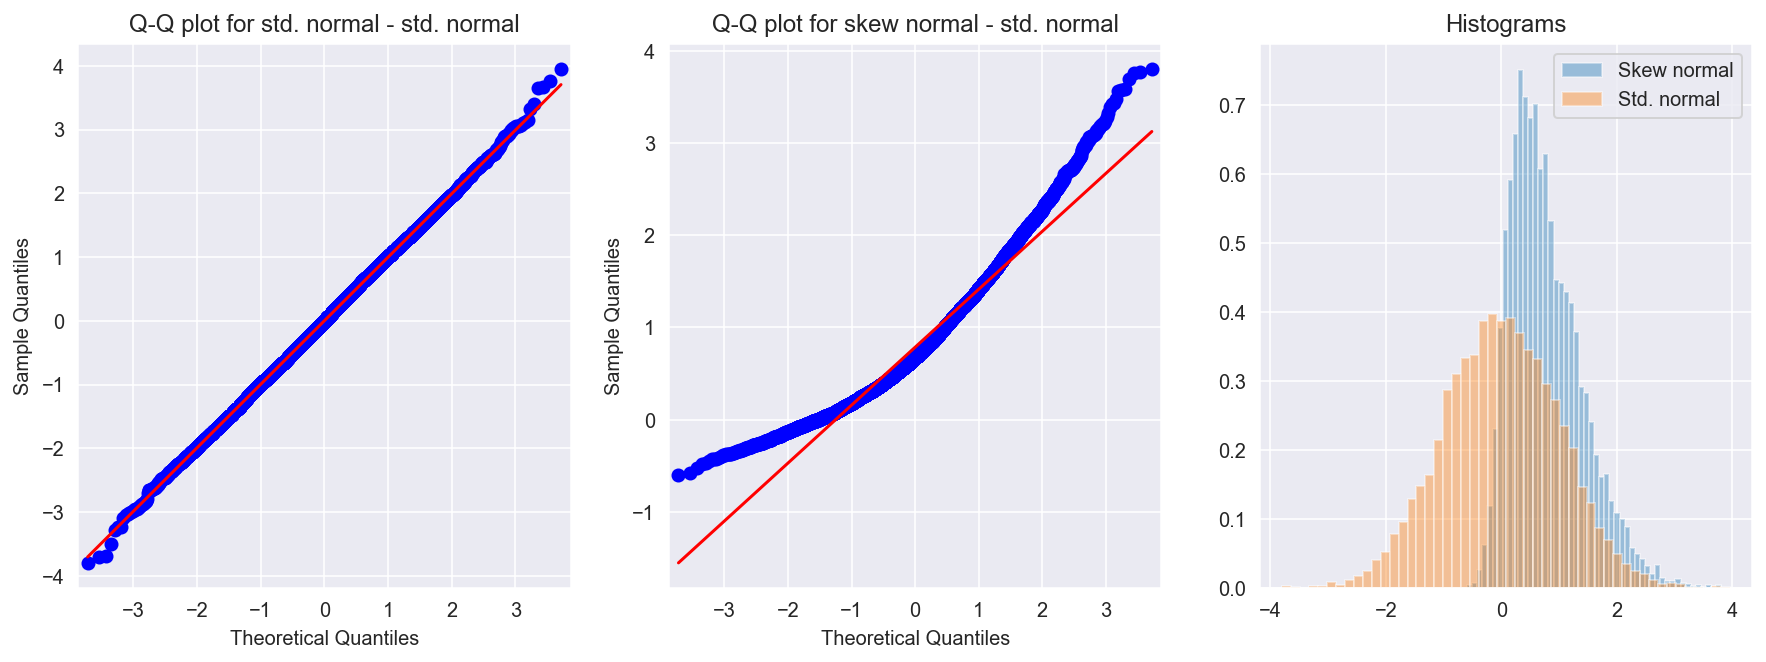

In [34]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.api import ProbPlot
from scipy import stats

%config InlineBackend.figure_format ='retina'
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (10.0, 6.0)

# Comparing skew normal and standard normal

n = 10000
rv_std_normal = np.random.normal(size=n)
rv_skew_normal = stats.skewnorm.rvs(a=5, size=n)

fig, ax = plt.subplots(1, 3, figsize=(15,5))

ProbPlot(rv_std_normal).qqplot(line='s', ax=ax[0])
ax[0].set_title('Q-Q plot for std. normal - std. normal')

ProbPlot(rv_skew_normal).qqplot(line='s', ax=ax[1])
ax[1].set_title('Q-Q plot for skew normal - std. normal')

sns.distplot(rv_skew_normal, kde=False, norm_hist=True, label='Skew normal', ax=ax[2])
sns.distplot(rv_std_normal, kde=False, norm_hist=True, label='Std. normal', ax=ax[2])
ax[2].set_title('Histograms')
ax[2].legend();

As expected, data from a standard normal distribution fits almost perfectly onto standard normal quantiles, while data from our positively skewed distribution does not -- it has more probability mass for lower values, as well as more extreme higher values.

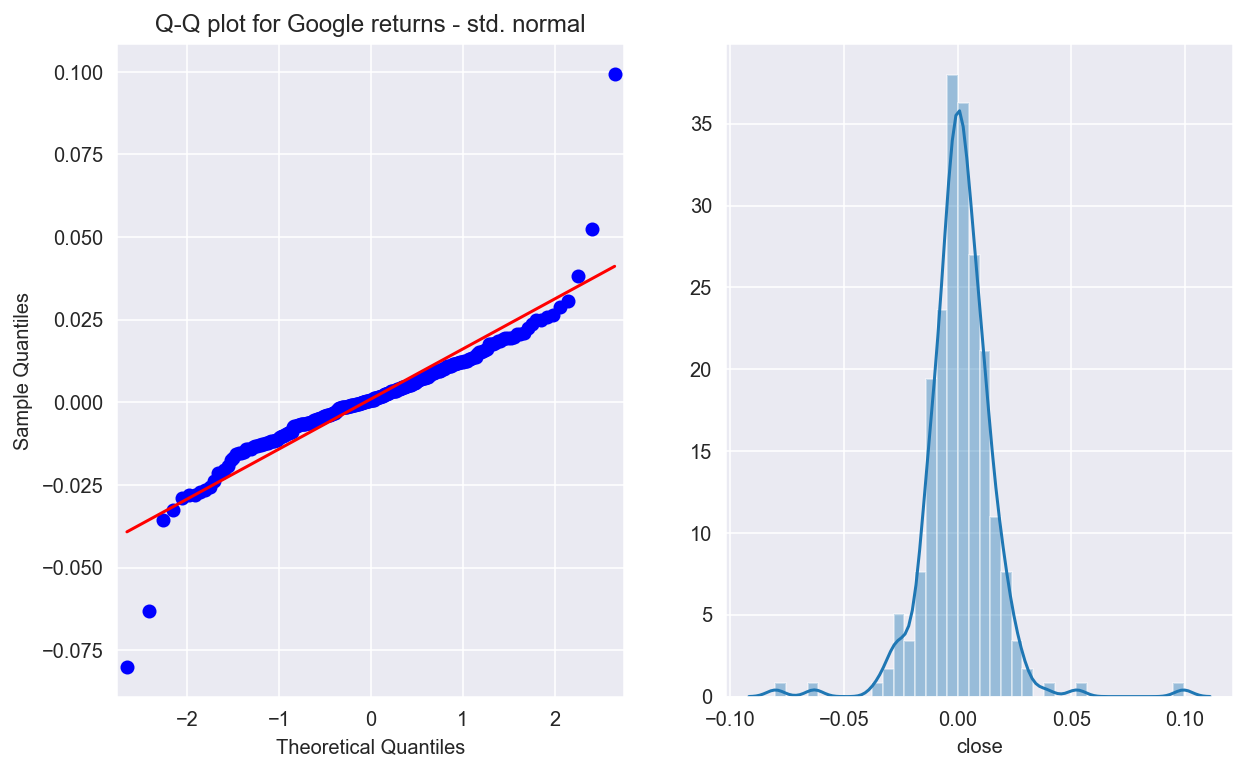

In [114]:
# Comparing Google stock returns to standard normal

import os
import pandas_datareader as pdr
from dotenv import load_dotenv
from datetime import datetime
load_dotenv()

start = datetime(2019, 1, 1)
end = datetime(2019, 12, 31)
key = os.getenv('tiingo_api_key')

goog = np.log(pdr.get_data_tiingo('GOOG', start, end, api_key=key)['close']).diff().dropna()

fix, ax = plt.subplots(1, 2)

ProbPlot(nflx).qqplot(line='s', ax=ax[0])
ax[0].set_title('Q-Q plot for Google returns - std. normal')

sns.distplot(nflx, norm_hist=True, ax=ax[1]);

The above graph shows clearly that Google's daily stock returns are not normally distributed. While the inner part of the distribution fits a normal distribution relatively well, the returns distribution has (very) fat tails. 

Chi-Squared distribution

- To assess goodness of fit.

F distribution

- Can be used to measure whether means of different treatment groups differ from control condition.
- F-statistic is calculated as the ratio of the variance between groups and the variance within groups (ANOVA).
- F distribution gives all values that would be produced if between variance were zero (i.e. under the null model).
- Df is given by the number of groups we compare.

Poisson distribution

- Useful to model processes that randomly generate outcomes at a constant rate (e.g. processes like arrivals that vary over time, or number of defects or typos that vary over space).
- The parameter of the distribution is lambda, which is both the rate per unit of time and the variance.
- The poisson and exponential distribution can be very useful when modelling, say, arrivals and waiting times. It's important, though, to remember the three key assumptions: 1) lambda remains constant across intervals, 2) events are independent, and 3) two events cannot occur at the same time.
- To account for 1), defining the intervals such that they are sufficiently homogenous often helps.

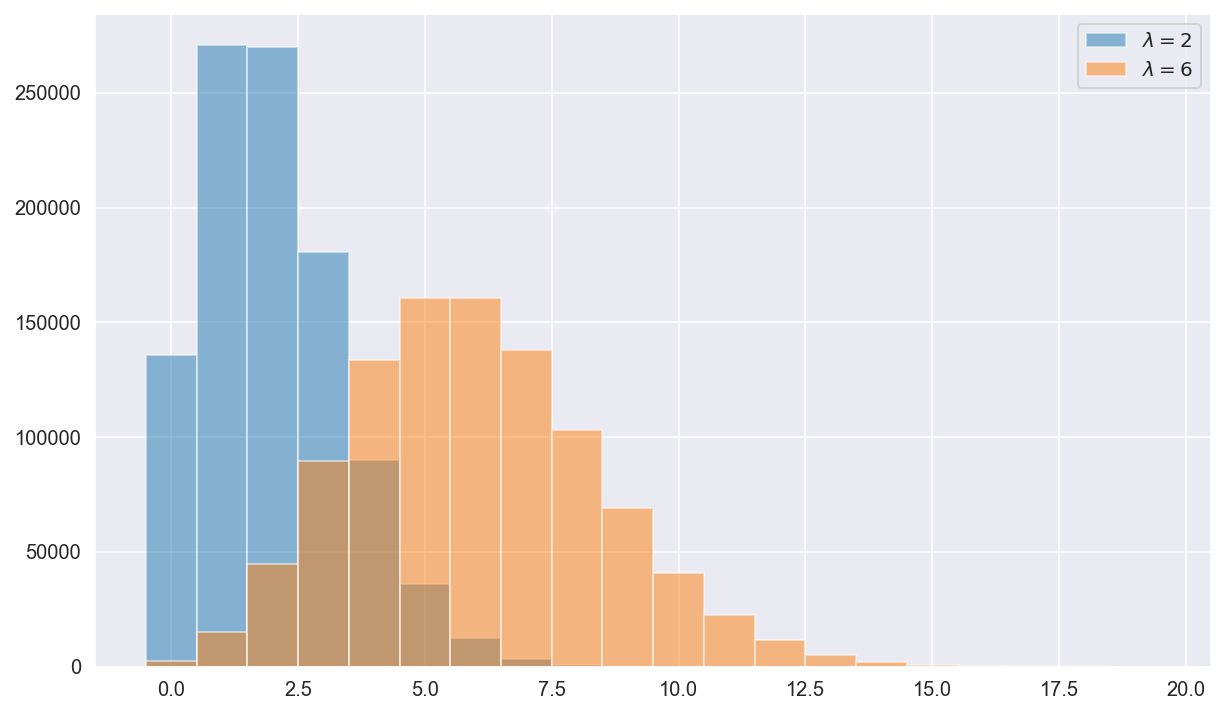

In [184]:
# Comparing Poisson distributions

x = np.random.poisson(2, 1000000)
y = np.random.poisson(6, 1000000)
plt.hist(x, alpha=0.5, label='$\\lambda = 2$', bins=np.arange(min(x), max(x))-0.5)
plt.hist(y, alpha=0.5, label='$\\lambda = 6$', bins=np.arange(min(y), max(y))-0.5)
plt.legend();

Exponential distribution

- Takes the same parameter lambda as the Poisson distribution, but can be used to model the time between random events occuring at a frequent rate lambda (i.e. the time/space difference between Poisson events).

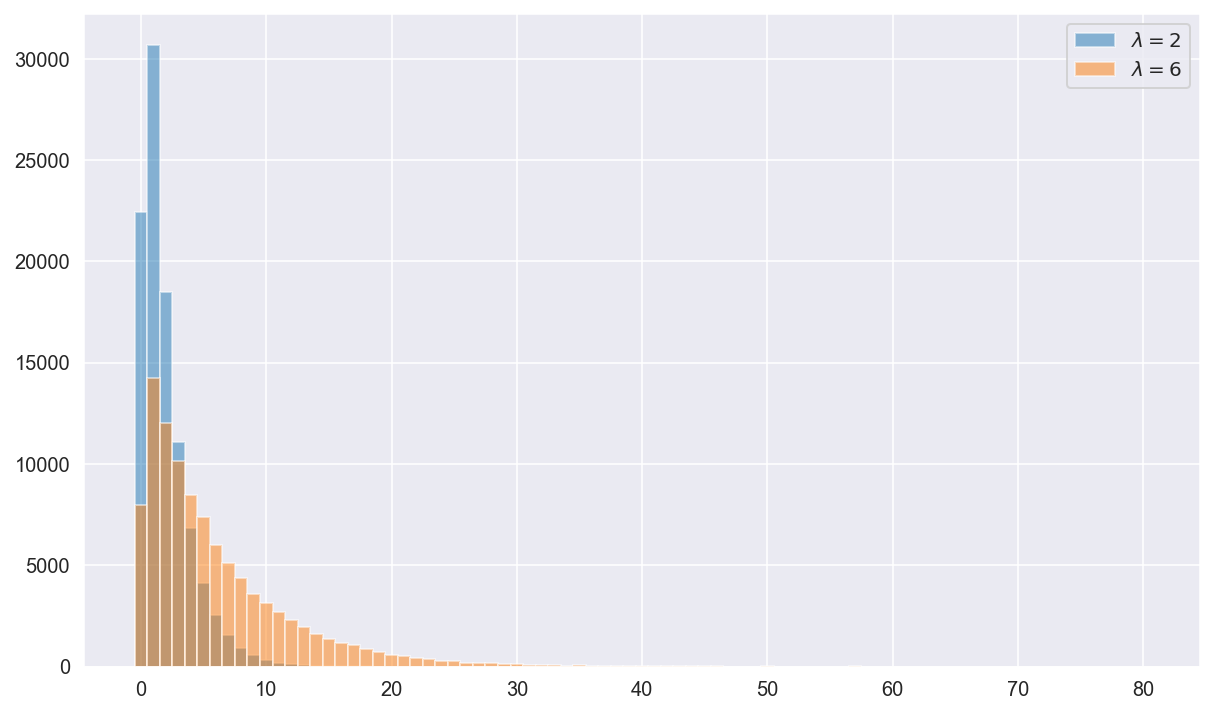

In [189]:
# Comparing exponential distributions

n = 100000
x = np.random.exponential(2, n)
y = np.random.exponential(6, n)
plt.hist(x, alpha=0.5, label='$\\lambda = 2$', bins=np.arange(min(x), max(x))-0.5)
plt.hist(y, alpha=0.5, label='$\\lambda = 6$', bins=np.arange(min(y), max(y))-0.5)
plt.legend();

Weibull distribution

- Used to model events for which the event rate changes during the time of the interval, and thus violates the poisson and exponential assumption.
- An example is mechanical failure, where the probability of failure increases as time goas by.
- Parameters of the distribution are $\eta$, the scale parameter, and $\beta$, the shape parameter ($\beta > 1$ indicates increasing probability of an event over time, $\beta < 1$ decreasing probability).

Linear regression and regression diagnostic

Follow [this](https://github.com/erykml/medium_articles/blob/master/Statistics/linear_regression_assumptions.ipynb) notebook.

# Misc

### Comparing speed of generating random samples with numpy and scipy

In [25]:
%%timeit
np.random.normal(size=10)

3.34 µs ± 38 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [24]:
%%timeit
norm.rvs(size=10)

33.9 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Turns out numpy is about ten times faster –- 3.3 microseconds (10e^-6s) compared to 33 microseconds.

### Plotting distributions in Seaborn

In [54]:
# Generating random samples

n = 10000
rv_std_normal = np.random.normal(size=n)
rv_normal = np.random.normal(1, 2.5, n)
rv_skew_normal = stats.skewnorm.rvs(a=5, size=n)

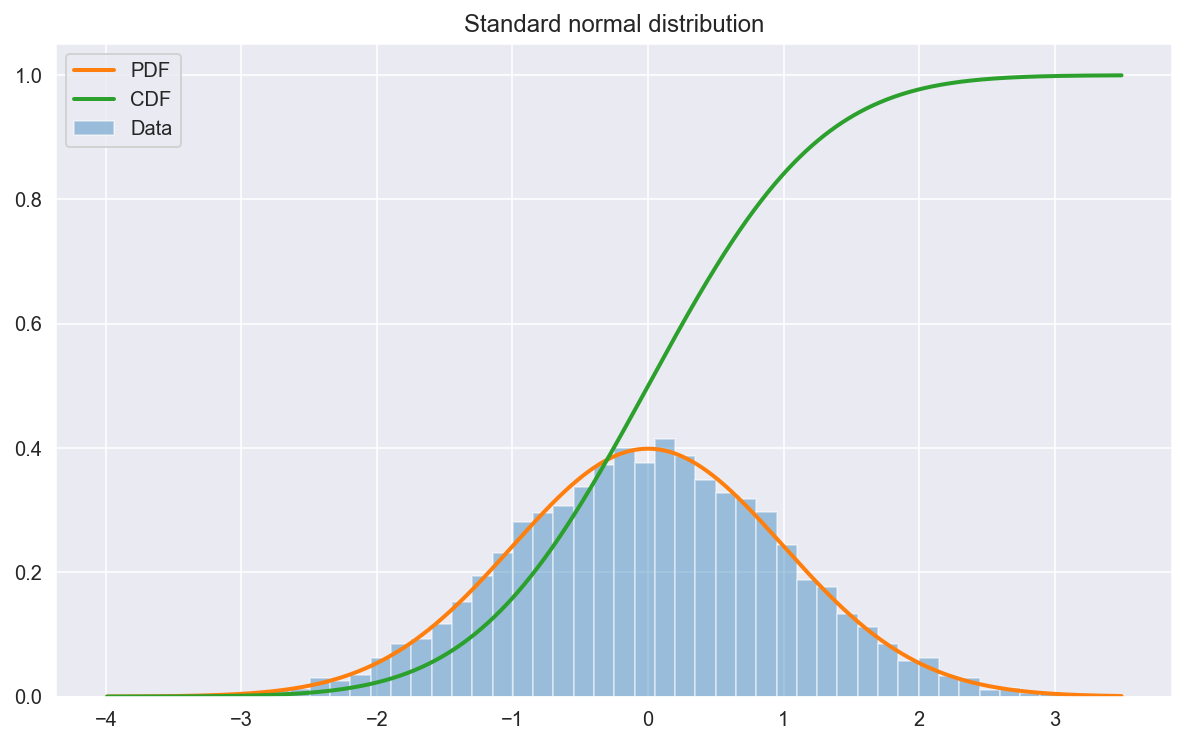

In [55]:
# Drawing histogram, pdf, and cdf of std normal sample

x = np.linspace(min(rv_std_normal), max(rv_std_normal), 1000);

pdf = stats.norm.pdf(x)
cdf = stats.norm.cdf(x)

ax = sns.distplot(rv_std_normal, kde=False, norm_hist=True, label='Data')
ax.plot(x, pdf, lw=2, label='PDF')
ax.plot(x, cdf, lw=2, label='CDF')

ax.set_title('Standard normal distribution')
ax.legend();

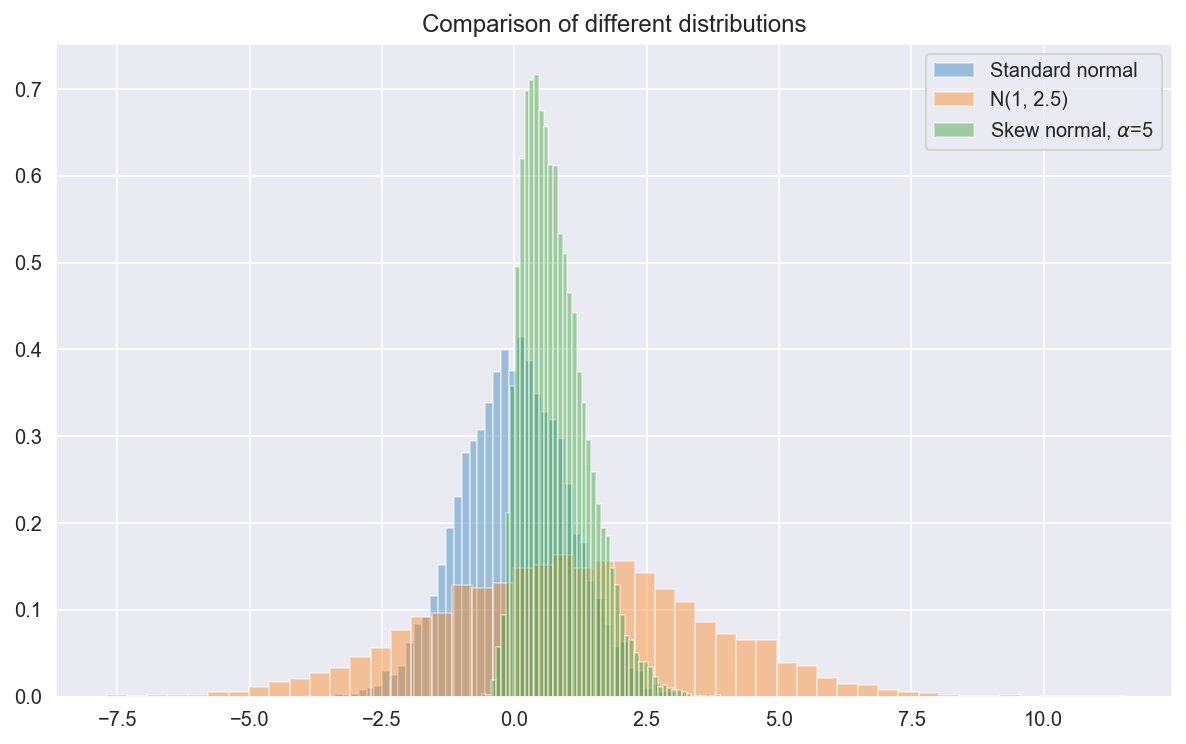

In [56]:
# Compare three distributions

ax = sns.distplot(rv_std_normal, kde=False, norm_hist=True, label='Standard normal')
ax = sns.distplot(rv_normal, kde=False, norm_hist=True, label='N(1, 2.5)')
ax = sns.distplot(rv_skew_normal, kde=False, norm_hist=True, label='Skew normal, $\\alpha$=5')
ax.set_title('Comparison of different distributions')
ax.legend();